# Setup

In [48]:
import pyral
import pandas as pd
import numpy as np
import sabre
import matplotlib.pyplot as plt
from datetime import datetime

date_format = r"%Y-%m-%dT%H:%M:%S.%fZ"

#setting default plot figure size
plt.rcParams['figure.figsize'] = [8, 4] # width x height (in inches)
plt.rcParams['figure.dpi'] = 150 # dpi


#team = "Naos (TDS-KRK)"   
#team = "OrderSvc-KRK-TEAM2-IFS-45387011"   
team = "Access Guardians"
#team = "Identity Management" 
#team = "OrderSvc-KRK-TEAM6-IFS-46336961" 

from_date = "2020-10-01"
to_date = "today"


# Establishing connection to Rally

In [49]:
rally = sabre.open_rally_connection(project=team)

# Calculating Cycle Time

## Fetching user story data

In [51]:


user_story_query = ( f'((AcceptedDate >= "{from_date}") AND (AcceptedDate <= "{to_date}"))')

response = rally.get("User Story", query=user_story_query, fetch=True) 
response_data = [(us.FormattedID, us.Name, us.ScheduleState, us.PlanEstimate, 
                    datetime.strptime(us.InProgressDate, date_format),
                    datetime.strptime(us.AcceptedDate, date_format)) for us in response]
df_user_story = pd.DataFrame(response_data, columns=['Id', 'Title', 'State', 'Estimate', 'InProgressDate', 'AcceptedDate'])

df_user_story["CycleTime"] = df_user_story["AcceptedDate"] - df_user_story["InProgressDate"]

ct_mean = df_user_story["CycleTime"].dt.days.mean()
ct_std_dev = df_user_story["CycleTime"].dt.days.std()
ct_limit = int(np.ceil( ct_mean + ct_std_dev * 3 ))

df_user_story


,Id,Title,State,Estimate,InProgressDate,AcceptedDate,CycleTime
0,US538359,[ESM/ESSMWS] Update CERT and INT LDAP config t...,Accepted,2.0,2020-10-14 09:13:09.084,2020-10-19 08:17:57.335,4 days 23:04:48.251000
1,US691851,[11/17] [WAM][ASTSECSYS-1888] PROD Prepare age...,Accepted,2.0,2020-11-09 08:58:05.609,2020-11-20 09:07:25.081,11 days 00:09:19.472000
2,US911581,Prepare and send by 11/5 and Import by 11/5 me...,Accepted,2.0,2020-10-27 12:31:13.489,2020-11-10 09:19:16.766,13 days 20:48:03.277000
3,US942934,[ESSM][SONAR] Fix multiple small code problems...,Accepted,1.0,2020-12-09 22:36:47.916,2020-12-17 09:30:43.954,7 days 10:53:56.038000
4,US949064,[Tracking] Process of incapsula onboarding for...,Accepted,1.0,2020-08-12 11:22:45.843,2021-01-07 09:03:03.880,147 days 21:40:18.037000
...,...,...,...,...,...,...,...
287,US1095736,[Tracking] Find why we see additional entries ...,Accepted,1.0,2021-03-05 07:53:06.832,2021-03-08 09:06:09.498,3 days 01:13:02.666000
288,US1095916,Support agent migration (#6),Accepted,0.0,2021-03-09 11:51:28.209,2021-03-22 11:23:51.353,12 days 23:32:23.144000
289,US1098003,Learn ATK hardening design - continuation part 2,Accepted,0.0,2021-03-09 08:40:40.333,2021-03-22 11:27:57.036,13 days 02:47:16.703000
290,US1098625,Maintenance tasks - iteration 6,Accepted,0.0,2021-03-11 15:00:22.176,2021-03-22 11:36:18.728,10 days 20:35:56.552000


## Cycle Time Histogram

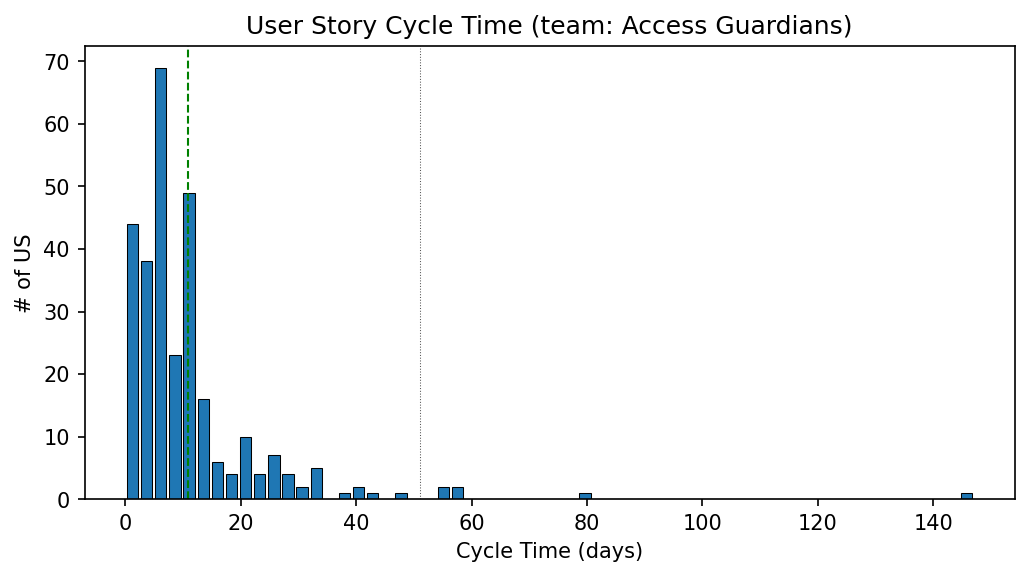

In [52]:
plt.hist(df_user_story["CycleTime"].dt.days, edgecolor='#000000', linewidth=0.5, rwidth=0.8, bins=60)
plt.title(f"User Story Cycle Time (team: {team})")
plt.xlabel("Cycle Time (days)")
plt.ylabel("# of US")

plt.axvline(ct_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(ct_mean + ct_std_dev * 3, color='#555555', linestyle='dotted', linewidth=0.5)

plt.show()

## Cycle Time Histogram (limited data)

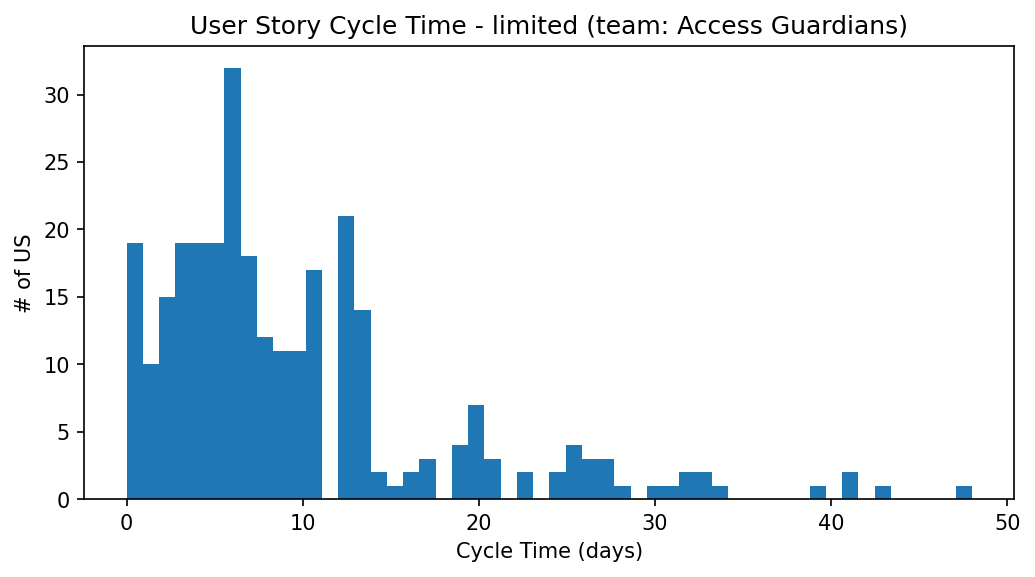

In [63]:
df_user_story_limited = df_user_story[df_user_story["CycleTime"].dt.days <= ct_limit]

#plt.hist(df_user_story_limited["CycleTime"].dt.days, edgecolor='#000000', linewidth=0.5, rwidth=0.8, bins=ct_limit)
plt.hist(df_user_story_limited["CycleTime"].dt.days, bins=int(ct_limit * 1.0))
plt.title(f"User Story Cycle Time - limited (team: {team})")
plt.xlabel("Cycle Time (days)")
plt.ylabel("# of US")
plt.show()

In [54]:
df_days_cycletime = df_user_story[["CycleTime"]].copy()
df_days_cycletime["CycleTime"] = df_days_cycletime["CycleTime"].dt.days

df_days_cycletime.describe()

,CycleTime
count,292.000000
mean,10.900685
std,13.405405
min,0.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,147.000000


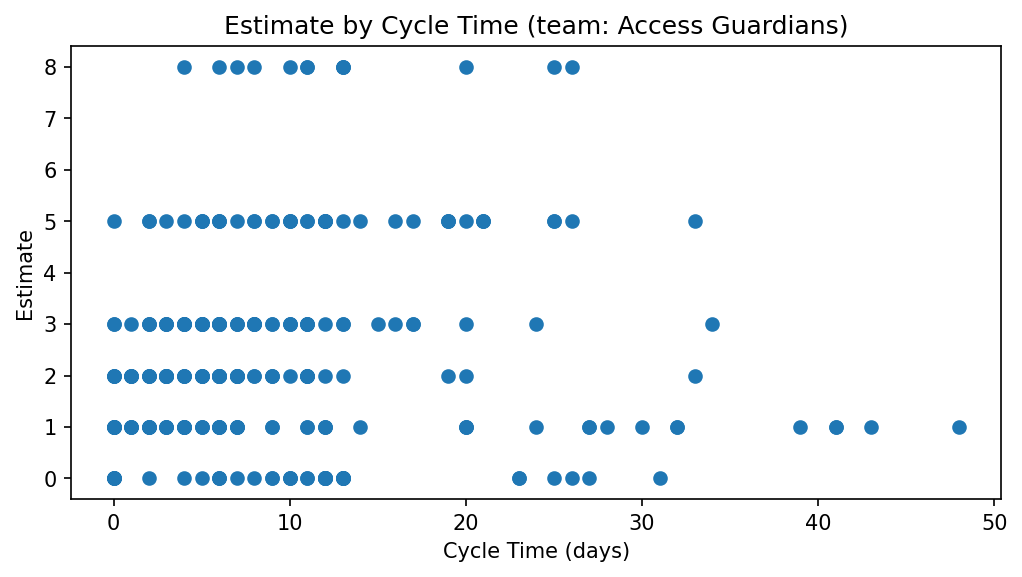

In [55]:
df_plot_data = df_user_story[["CycleTime", "Estimate"]].copy()
df_plot_data["CycleTime"] = df_plot_data["CycleTime"].dt.days


#plt.scatter(data=df_plot_data, x = "CycleTime", y = "Estimate" )
plt.scatter(data=df_plot_data[df_plot_data["CycleTime"] <= ct_limit], x = "CycleTime", y = "Estimate" )
plt.title(f"Estimate by Cycle Time (team: {team})")
plt.xlabel("Cycle Time (days)")
plt.ylabel("Estimate")
plt.show()


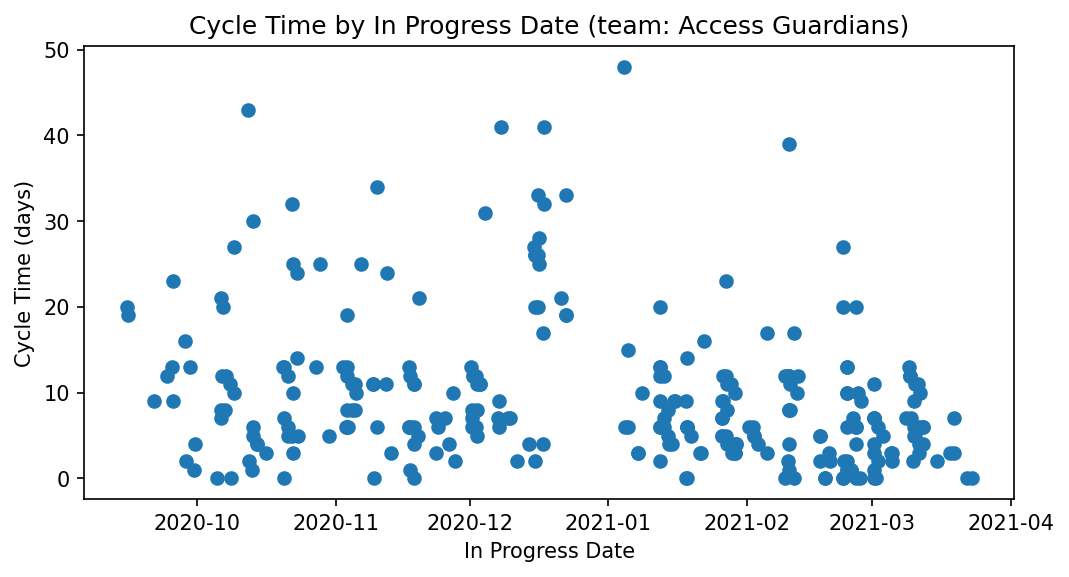

In [56]:
df_plot_data = df_user_story[["CycleTime", "InProgressDate"]].copy()
df_plot_data["CycleTime"] = df_plot_data["CycleTime"].dt.days

plt.scatter(data=df_plot_data[df_plot_data["CycleTime"] <= ct_limit], y = "CycleTime", x = "InProgressDate" )
plt.title(f"Cycle Time by In Progress Date (team: {team})")
plt.ylabel("Cycle Time (days)")
plt.xlabel("In Progress Date")
plt.show()

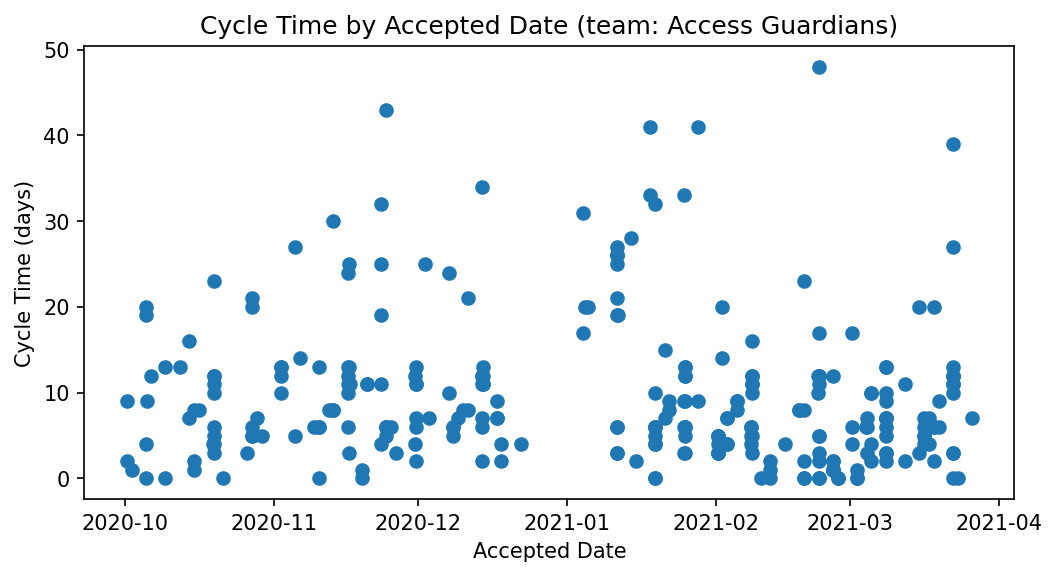

In [58]:
df_plot_data = df_user_story[["CycleTime", "AcceptedDate"]].copy()
df_plot_data["CycleTime"] = df_plot_data["CycleTime"].dt.days

plt.scatter(data=df_plot_data[df_plot_data["CycleTime"] <= ct_limit], y = "CycleTime", x = "AcceptedDate" )
plt.title(f"Cycle Time by Accepted Date (team: {team})")
plt.ylabel("Cycle Time (days)")
plt.xlabel("Accepted Date")
plt.show()